# Placebo test

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
import pymc as pm
import arviz as az

rng = np.random.default_rng(42)
figsize = (10, 5)
az.style.use("arviz-darkgrid")

In [2]:
filepath = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

In [85]:
placebo_year = 1985

pre_treatment_data = df[(df['after_treatment'] == 0) & (df['year'] >= 1970) & (df['year'] <= 2000)].copy()
pre_treatment_data.loc[(pre_treatment_data['treatment_group'] == 0), 'placebo_treatment'] = 0
pre_treatment_data.loc[(pre_treatment_data['year'] < placebo_year) & (pre_treatment_data['treatment_group'] == 1), 'placebo_treatment'] = 0
pre_treatment_data.loc[(pre_treatment_data['year'] >= placebo_year) & (pre_treatment_data['treatment_group'] == 1), 'placebo_treatment'] = 1

df_ = pre_treatment_data.copy()
# 島ごとの平均人口
df_['log_pop_m_island'] = df_['log_pop'] - df_.groupby('island_ids')['log_pop'].transform('mean')
# 年ごとの平均人口
df_['log_pop_m_island_year'] = df_['log_pop_m_island'] - df_.groupby('year')['log_pop_m_island'].transform('mean')
# 戻す
pre_treatment_data['log_pop_star'] = df_['log_pop_m_island_year']

In [86]:
pre_treatment_data[['island_ids', 'year', 'treatment_group', 'placebo_treatment', 'log_pop_star']][df['treatment_group'] == 0].describe()

/tmp/ipykernel_40727/3690917391.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pre_treatment_data[['island_ids', 'year', 'treatment_group', 'placebo_treatment', 'log_pop_star']][df['treatment_group'] == 0].describe()


,island_ids,year,treatment_group,placebo_treatment,log_pop_star
count,315.000000,315.000000,315.0,315.0,273.000000
mean,143.466667,1985.000000,0.0,0.0,0.039590
std,47.828395,10.015911,0.0,0.0,0.217017
min,69.000000,1970.000000,0.0,0.0,-1.194564
25%,101.000000,1975.000000,0.0,0.0,-0.070589
50%,140.000000,1985.000000,0.0,0.0,0.035005
75%,190.000000,1995.000000,0.0,0.0,0.138719
max,218.000000,2000.000000,0.0,0.0,0.569858


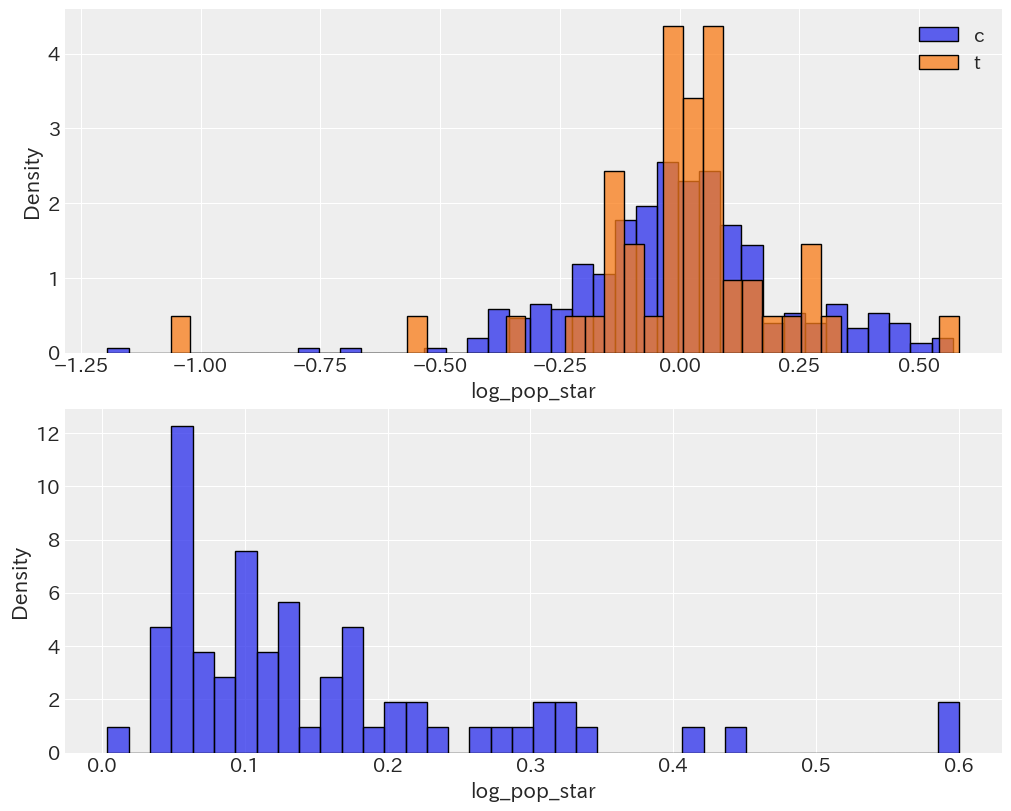

In [120]:
y_std_i = pre_treatment_data.groupby('island_ids')['log_pop_star'].std()

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sns.histplot(pre_treatment_data['log_pop_star'][pre_treatment_data['placebo_treatment'] == 0], bins=40, ax=ax[0], label='c', stat='density')
sns.histplot(pre_treatment_data['log_pop_star'][pre_treatment_data['placebo_treatment'] == 1], bins=40, ax=ax[0], label='t', stat='density')
sns.histplot(y_std_i, bins=40, ax=ax[1], stat='density')
ax[0].legend()

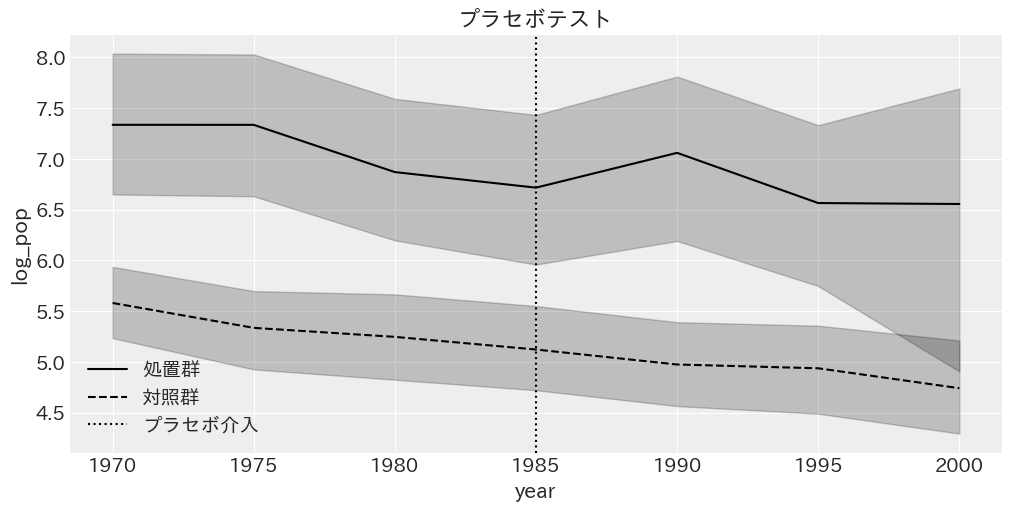

In [121]:
# プロットによる視覚化
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(data=pre_treatment_data[pre_treatment_data['treatment_group'] == 1], x='year', y='log_pop', label='処置群', ax=ax, color='black')
sns.lineplot(data=pre_treatment_data[pre_treatment_data['treatment_group'] == 0], x='year', y='log_pop', label='対照群', ax=ax, color='black', linestyle='--')
ax.axvline(x=placebo_year, color='black', linestyle=':', label='プラセボ介入')
ax.legend()
ax.set_title('プラセボテスト')
plt.show()

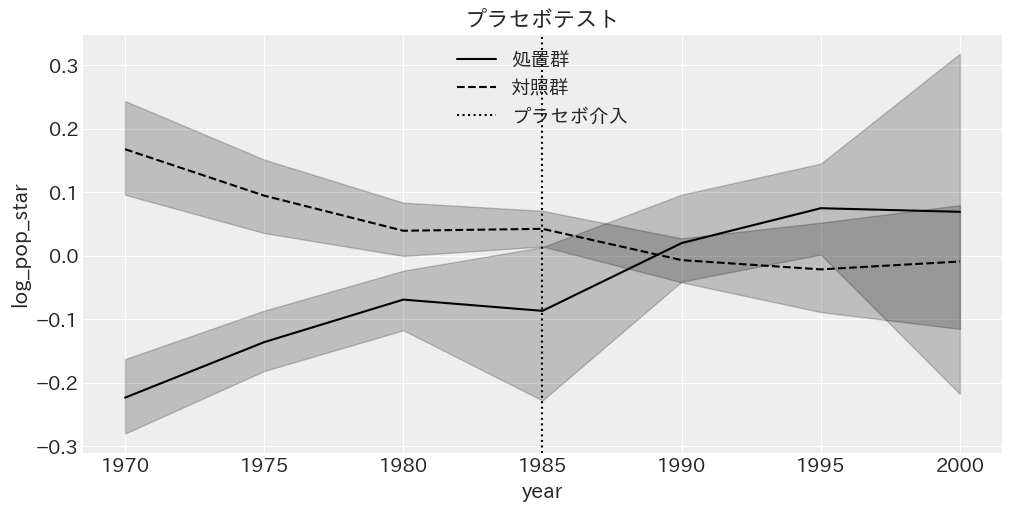

In [122]:
# プロットによる視覚化
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(data=pre_treatment_data[pre_treatment_data['treatment_group'] == 1], x='year', y='log_pop_star', label='処置群', ax=ax, color='black')
sns.lineplot(data=pre_treatment_data[pre_treatment_data['treatment_group'] == 0], x='year', y='log_pop_star', label='対照群', ax=ax, color='black', linestyle='--')
ax.axvline(x=placebo_year, color='black', linestyle=':', label='プラセボ介入')
ax.legend()
ax.set_title('プラセボテスト')
plt.show()

## 頻度主義

In [91]:
formula = 'log_pop_star ~ placebo_treatment - 1'
y, X = dmatrices(formula, pre_treatment_data, return_type='dataframe')
freaq_model = sm.OLS(y, X)
result = freaq_model.fit(cov_type='HC1')
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:           log_pop_star   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.003
Method:                 Least Squares   F-statistic:                           0.002443
Date:                Sun, 05 Jan 2025   Prob (F-statistic):                       0.961
Time:                        16:03:49   Log-Likelihood:                          38.985
No. Observations:                 396   AIC:                                     -75.97
Df Residuals:                     395   BIC:                                     -71.99
Df Model:                           1                                                  
Covariance Type:                  HC1                                                  
                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

# Bayes

In [106]:
island_ids, unique_island_ids = pd.factorize(pre_treatment_data['island_ids'])
n_islands = len(unique_island_ids)

with pm.Model() as model:
    model.add_coords({'obs_id': np.arange(len(pre_treatment_data))})

    # data
    # island_ids = pm.Data('island_ids', island_ids)

    # prior
    beta = pm.Normal('beta', mu=0, sigma=0.1)
    sigma = pm.HalfCauchy('sigma', beta=0.15)
    nu = pm.Gamma('nu', alpha=2, beta=0.1)

    # likelihood
    mu = beta * pre_treatment_data['placebo_treatment']
    y = pm.StudentT('y', mu=mu, sigma=sigma, nu=nu, observed=pre_treatment_data['log_pop_star'], dims='obs_id')

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


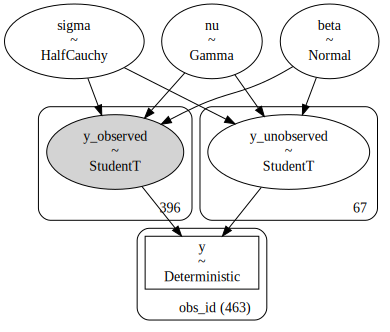

In [107]:
pm.model_to_graphviz(model)

In [108]:
with model:
    trace = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        nuts_sampler='numpyro',
        random_seed=rng
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [110]:
az.summary(trace, var_names=['beta', 'sigma', 'nu'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.018,0.024,-0.026,0.066,0.000,0.000,15674.0,6321.0,1.0
sigma,0.164,0.012,0.142,0.186,0.000,0.000,5966.0,5508.0,1.0
nu,4.715,1.407,2.580,7.265,0.018,0.013,6194.0,5760.0,1.0


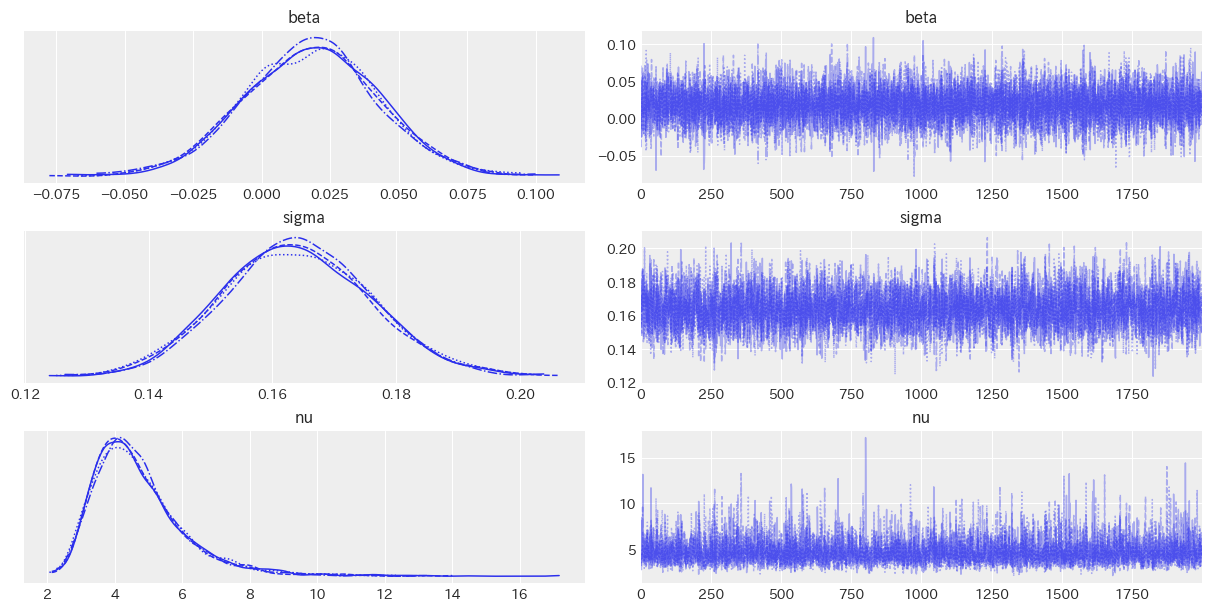

In [112]:
az.plot_trace(trace, var_names=['beta', 'sigma', 'nu']);

<Axes: title={'center': 'beta'}>

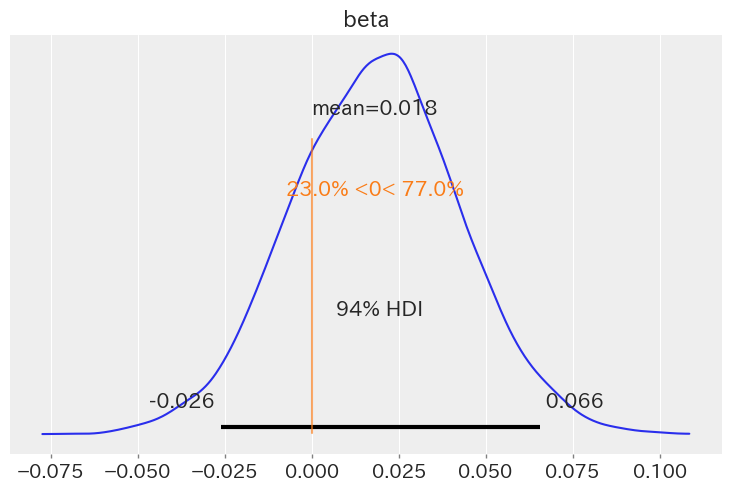

In [114]:
az.plot_posterior(trace, var_names=['beta'], ref_val=0)

In [115]:
with model:
    pm.compute_log_likelihood(trace)

Output()

In [116]:
az.waic(trace)

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 8000 posterior samples and 396 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    56.97    19.41
p_waic        3.11        -

There has been a warning during the calculation. Please check the results.